In [1]:
from spark_utils import get_spark_session

spark = get_spark_session()
# run format_data.py if these don't exist
train_data = spark.read.parquet('data/amex-default-prediction/train_data')
train_labels = spark.read.parquet('data/amex-default-prediction/train_labels')
# test_data = spark.read.parquet('data/amex-default-prediction/test_data')
# sample_submission = spark.read.parquet('data/amex-default-prediction/sample_submission')

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/20 04:09:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from format_data import TARGET_VARIABLE
from pyspark.sql.window import Window
import pyspark.sql.functions as F

window_latest_date_by_id = (
    Window
    .partitionBy('customer_ID')
    .orderBy(F.col('S_2').desc())
    .rangeBetween(
        Window.unboundedPreceding,
        Window.unboundedFollowing,
    )
)

train_data = (
    train_data
    .join(train_labels, on='customer_ID', how='inner')
    .withColumn('S_2_max', F.max('S_2').over(window_latest_date_by_id))
    .withColumn('days_to_S_2_max', F.datediff(end='S_2_max', start='S_2'))
)

In [3]:
%%time
from format_data import CATEGORICAL_VARIABLES
from encoder import CategoricalToIntegerEncoders
from format_data import TARGET_VARIABLE, DATE_VARIABLES, ID_VARIABLES


encs = CategoricalToIntegerEncoders(columns=CATEGORICAL_VARIABLES).fit(train_data)

train_data_splits = train_data.randomSplit(weights=[.9, .1], seed=20220619)
fit_data, valid_data = train_data_splits[0], train_data_splits[1]

fit_pdf = encs.transform(spark=spark, df=fit_data).toPandas()
valid_pdf = encs.transform(spark=spark, df=valid_data).toPandas()

feature_columns = [
    c for c in fit_pdf.columns 
    if c not in [
        TARGET_VARIABLE,
        *ID_VARIABLES,
        *DATE_VARIABLES.keys(),
        'S_2_max', 'days_to_S_2_max',
    ]
]
print(
    f'fit_pdf.shape: {fit_pdf.shape}\n',
    'feature_columns\n', ', '.join(feature_columns)
)

22/06/20 04:10:08 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


fit_pdf.shape: (4977965, 193)
 feature_columns
 P_2, D_39, B_1, B_2, R_1, S_3, D_41, B_3, D_42, D_43, D_44, B_4, D_45, B_5, R_2, D_46, D_47, D_48, D_49, B_6, B_7, B_8, D_50, D_51, B_9, R_3, D_52, P_3, B_10, D_53, S_5, B_11, S_6, D_54, R_4, S_7, B_12, S_8, D_55, D_56, B_13, R_5, D_58, S_9, B_14, D_59, D_60, D_61, B_15, S_11, D_62, D_65, B_16, B_17, B_18, B_19, B_20, S_12, R_6, S_13, B_21, D_69, B_22, D_70, D_71, D_72, S_15, B_23, D_73, P_4, D_74, D_75, D_76, B_24, R_7, D_77, B_25, B_26, D_78, D_79, R_8, R_9, S_16, D_80, R_10, R_11, B_27, D_81, D_82, S_17, R_12, B_28, R_13, D_83, R_14, R_15, D_84, R_16, B_29, S_18, D_86, D_87, R_17, R_18, D_88, B_31, S_19, R_19, B_32, S_20, R_20, R_21, B_33, D_89, R_22, R_23, D_91, D_92, D_93, D_94, R_24, R_25, D_96, S_22, S_23, S_24, S_25, S_26, D_102, D_103, D_104, D_105, D_106, D_107, B_36, B_37, R_26, R_27, D_108, D_109, D_110, D_111, B_39, D_112, B_40, S_27, D_113, D_115, D_118, D_119, D_121, D_122, D_123, D_124, D_125, D_127, D_128, D_129, B_41, B_

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(len(feature_columns), 10)
        self.linear2 = nn.Linear(10, 1)
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(F.relu(x))
        x = self.softplus(x)
        return x

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import torch

def log_surv(scale: torch.tensor, t: torch.tensor) -> torch.tensor:
    return -t/scale

def log_density(scale: torch.tensor, t: torch.tensor) -> torch.tensor:
    return -torch.log(scale) - t / scale

def nll(scale: torch.tensor, days_to_last_statement: torch.tensor, is_defaulted: torch.tensor):
    return -torch.mean(torch.where(
        is_defaulted, 
        log_density(scale=scale, t=days_to_last_statement),
        log_surv(scale=scale, t=days_to_last_statement),
    ))

In [6]:
import torch.optim as optim
import numpy as np

m = Model()
optimizer = optim.SGD(m.parameters(), lr=0.01, momentum=0.9)

for i in range(1000):
    fit_pdf_small = fit_pdf.sample(10000, ignore_index=True)

    inputs = torch.tensor(np.array(fit_pdf_small[feature_columns])).float()
    days_to_last_statement = torch.tensor(fit_pdf_small['days_to_S_2_max']).reshape((-1, 1)).float()
    is_defaulted = torch.tensor(fit_pdf_small[TARGET_VARIABLE] == 1.).reshape((-1, 1))

    optimizer.zero_grad()
    rate = m(torch.nan_to_num(inputs))
    loss = nll(rate, days_to_last_statement, is_defaulted)
    if i % 25 == 0:
        print(i, loss.item())

    torch.nn.utils.clip_grad_norm_(m.parameters(), max_norm=1.)
    loss.backward()
    optimizer.step()


0 230.46420288085938
25 1.8560343980789185
50 1.8545500040054321
75 1.9213353395462036
100 1.8834152221679688
125 1.8689380884170532
150 1.8640097379684448
175 1.8883086442947388
200 1.8936165571212769
225 1.871097445487976
250 1.8700358867645264
275 1.8781380653381348
300 1.883968710899353
325 1.9233498573303223
350 1.8555269241333008
375 1.9070683717727661
400 1.8933988809585571
425 1.8663082122802734
450 1.9377460479736328
475 1.9025698900222778
500 1.9073834419250488
525 1.8720800876617432
550 1.85960054397583
575 1.8625339269638062
600 1.869137167930603
625 1.860376000404358
650 1.946274995803833
675 1.9533494710922241
700 1.9040417671203613
725 1.8699954748153687
750 1.8589699268341064
775 1.863149642944336
800 1.866943359375
825 1.8913533687591553
850 1.8907136917114258
875 1.9061795473098755
900 1.8986752033233643
925 1.9014779329299927
950 1.8750722408294678
975 1.8865242004394531


In [7]:
from format_data import PREDICTION_VARIABLE
import pandas as pd

with torch.no_grad():
    inputs = torch.tensor(np.array(fit_pdf[feature_columns])).float()
    rate = np.array(m(torch.nan_to_num(inputs))).flatten()
    pred_df = pd.DataFrame({
        PREDICTION_VARIABLE: rate,
        'customer_ID': fit_pdf['customer_ID'],
        'S_2': fit_pdf['S_2'],
        'S_2_max': fit_pdf['S_2_max'],
    })

In [8]:
y_pred = pred_df.loc[pred_df['S_2'] == pred_df['S_2_max']].reset_index(drop=True)
y_pred = y_pred[['customer_ID', PREDICTION_VARIABLE]]
y_pred

,customer_ID,prediction
0,00093b69756b1afe3029c79b981e8d699b2a48bf4464a9...,956.319885
1,0012e41fe6caa3ba31b55b3de2030cbb77b01203aeb4a5...,673.563293
2,00582971eb87cf0bb643ed23cc0e0b3ad475379513c460...,1060.516479
3,00d769dbf0a5e3e73a8223566b33adc5686954dd337359...,1001.758606
4,00dbda372d97f23579e6946331110052ee81573eccd963...,717.985718
...,...,...
413054,ff9d4ec798248d6bb46685896f788c4319c8c6ad9e0929...,943.372070
413055,ffa47104b584db6ba11affb18ae14932320bac18bc0226...,1143.435425
413056,ffc0893ba6cd0c90d794da28bae8fa810ef9c17db24947...,939.362488
413057,ffd079877a5ab95c79aecb822639503213497119294ab7...,922.184814


In [9]:
y_true = fit_pdf.loc[fit_pdf['S_2'] == fit_pdf['S_2_max']].reset_index(drop=True)
y_true = y_true[['customer_ID', TARGET_VARIABLE]]
y_true

,customer_ID,target
0,00093b69756b1afe3029c79b981e8d699b2a48bf4464a9...,0.0
1,0012e41fe6caa3ba31b55b3de2030cbb77b01203aeb4a5...,0.0
2,00582971eb87cf0bb643ed23cc0e0b3ad475379513c460...,1.0
3,00d769dbf0a5e3e73a8223566b33adc5686954dd337359...,0.0
4,00dbda372d97f23579e6946331110052ee81573eccd963...,0.0
...,...,...
413054,ff9d4ec798248d6bb46685896f788c4319c8c6ad9e0929...,0.0
413055,ffa47104b584db6ba11affb18ae14932320bac18bc0226...,1.0
413056,ffc0893ba6cd0c90d794da28bae8fa810ef9c17db24947...,0.0
413057,ffd079877a5ab95c79aecb822639503213497119294ab7...,1.0


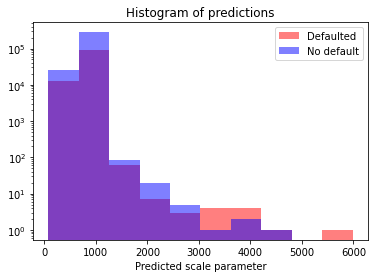

In [10]:
import matplotlib.pyplot as plt

n, bins, array = plt.hist(
    y_pred.loc[y_true[TARGET_VARIABLE] == 1.].reset_index(drop=True)[PREDICTION_VARIABLE],
    color=(1, 0, 0, .5),
    log=True,
    label='Defaulted'
)
n, bins, array = plt.hist(
    y_pred.loc[y_true[TARGET_VARIABLE] == 0.].reset_index(drop=True)[PREDICTION_VARIABLE],
    bins=bins,
    color=(0, 0, 1, .5),
    log=True,
    label='No default'
)
plt.xlabel('Predicted scale parameter')
plt.title('Histogram of predictions')
plt.legend()

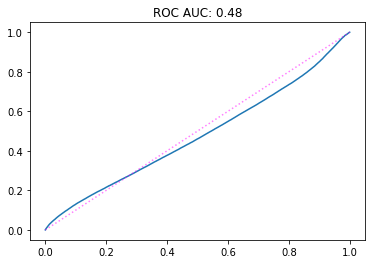

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(
    y_true[TARGET_VARIABLE], 
    y_pred[PREDICTION_VARIABLE],
)
v = roc_auc_score(
    y_true[TARGET_VARIABLE], 
    y_pred[PREDICTION_VARIABLE],
)
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, ls=':', color=(1, 0, 1, .5))
plt.title(f'ROC AUC: {v:.2f}')
plt.show()

In [11]:
from evaluation import amex_metric

amex_metric(y_true=y_true, y_pred=y_pred)

0.008171166286132146